# Compare models

1. Load available configurations
2. Load validation predictions
    - calculate absolute error
    - select top N for plotting by MAE from smallest (best) to largest (worst) (top N as specified, default 5)
    - correlation per sample, correlation per feat, correlation overall
    - MAE plots
3. Load test data predictions
    - as for validation data
    - top N based on validation data

In [1]:
import logging
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from IPython.display import display

import vaep
import vaep.imputation
import vaep.models
import vaep.nb
from vaep.analyzers import compare_predictions
from vaep.io import datasplits
from vaep.models.collect_dumps import collect, select_content

pd.options.display.max_rows = 30
pd.options.display.min_rows = 10
pd.options.display.max_colwidth = 100

plt.rcParams.update({'figure.figsize': (4, 2)})
vaep.plotting.make_large_descriptors(7)

logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.WARNING)


def load_config_file(fname: Path, first_split='config_') -> dict:
    with open(fname) as f:
        loaded = yaml.safe_load(f)
    key = f"{select_content(fname.stem, first_split=first_split)}"
    return key, loaded


def build_text(s):
    ret = ''
    if not np.isnan(s["latent_dim"]):
        ret += f'LD: {int(s["latent_dim"])} '
    try:
        if len(s["hidden_layers"]):
            t = ",".join(str(x) for x in s["hidden_layers"])
            ret += f"HL: {t}"
    except TypeError:
        # nan
        pass
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # change default to pickled files
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
models: str = 'Median,CF,DAE,VAE'  # picked models to compare (comma separated)
sel_models: str = ''  # user defined comparison (comma separated)
# Restrict plotting to top N methods for imputation based on error of validation data, maximum 10
plot_to_n: int = 5
feat_name_display: str = None  # display name for feature name in plural (e.g. 'protein groups')
save_agg_pred: bool = False  # save aggregated predictions of validation and test data

In [4]:
# Parameters
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/example"
models = "Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: fn_rawfile_metadata


root - INFO     Removed from global namespace: models


root - INFO     Removed from global namespace: sel_models


root - INFO     Removed from global namespace: plot_to_n


root - INFO     Removed from global namespace: feat_name_display


root - INFO     Removed from global namespace: save_agg_pred


{'folder_experiment': 'runs/example',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'models': 'Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP',
 'sel_models': '',
 'plot_to_n': 5,
 'feat_name_display': None,
 'save_agg_pred': False}

In [6]:
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/example/data'),
 'feat_name_display': None,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/example'),
 'models': 'Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'plot_to_n': 5,
 'save_agg_pred': False,
 'sel_models': ''}

In [7]:
figures = {}
dumps = {}

In [8]:
TARGET_COL = 'observed'
METRIC = 'MAE'
MIN_FREQ = None
MODELS_PASSED = args.models.split(',')
MODELS = MODELS_PASSED.copy()
FEAT_NAME_DISPLAY = args.feat_name_display
SEL_MODELS = None
if args.sel_models:
    SEL_MODELS = args.sel_models.split(',')

In [9]:
# list(sns.color_palette().as_hex()) # string representation of colors
if args.plot_to_n > 10:
    logger.warning("Set maximum of models to 10 (maximum)")
    args.overwrite_entry('plot_to_n', 10)

In [10]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_fake_na_val_test_splits.png


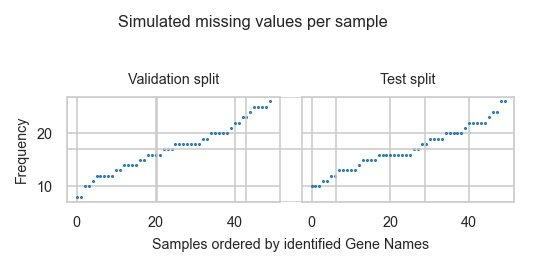

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)

vaep.plotting.data.plot_observations(data.val_y.unstack(), ax=axes[0],
                                     title='Validation split', size=1, xlabel='')
vaep.plotting.data.plot_observations(data.test_y.unstack(), ax=axes[1],
                                     title='Test split', size=1, xlabel='')
fig.suptitle("Simulated missing values per sample", size=8)
# hide axis and use only for common x label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(f'Samples ordered by identified {data.val_y.index.names[-1]}')
group = 1
fname = args.out_figures / f'2_{group}_fake_na_val_test_splits.png'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

## data completeness across entire data

In [12]:
# load frequency of training features...
# needs to be pickle -> index.name needed
freq_feat = vaep.io.datasplits.load_freq(args.data, file='freq_features.json')
freq_feat.head()  # training data

AAR2     45
ABCB6    35
ABHD11   30
ACAD9    50
ACTL6A   49
Name: freq, dtype: int64

<Axes: xlabel='Gene Names', ylabel='Proportion of identification in samples'>

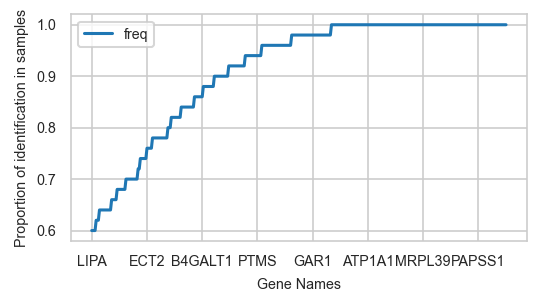

In [13]:
prop = freq_feat / len(data.train_X.index.levels[0])
prop.sort_values().to_frame().plot(
    xlabel=f'{data.val_y.index.names[-1]}',
    ylabel='Proportion of identification in samples')

View training data in wide format

In [14]:
data.to_wide_format()
data.train_X

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,28.294,27.258,27.386,30.671,31.671,32.601,32.223,29.028,NaN,27.438,...,27.006,30.132,28.042,31.767,30.773,29.513,33.780,26.050,31.650,30.839
2020_05_28_04_06_Q-Exactive-HF-X-Orbitrap_6070,28.023,27.669,NaN,30.908,32.045,32.831,32.357,NaN,32.790,NaN,...,27.433,30.005,28.055,31.617,30.620,30.399,34.001,28.353,31.478,NaN
2020_06_01_10_22_Q-Exactive-HF-X-Orbitrap_6070,NaN,NaN,NaN,27.885,NaN,32.261,30.111,NaN,29.862,27.587,...,25.167,NaN,NaN,NaN,28.168,26.706,31.973,26.948,30.807,25.095


Number of samples and features:

In [15]:
N_SAMPLES, M_FEAT = data.train_X.shape
print(f"N samples: {N_SAMPLES:,d}, M features: {M_FEAT}")

N samples: 50, M features: 376


Collect outputs in excel file:

In [16]:
fname = args.folder_experiment / '01_2_performance_summary.xlsx'
dumps[fname.stem] = fname
writer = pd.ExcelWriter(fname)
print(f"Saving to: {fname}")

Saving to: runs/example/01_2_performance_summary.xlsx


## Model specifications
- used for bar plot annotations

In [17]:
# model_key could be used as key from config file
? load only specified configs?
? case: no config file available?
all_configs = collect(
    paths=(fname for fname in args.out_models.iterdir()
           if fname.suffix == '.yaml'
           and 'model_config' in fname.name),
    load_fn=load_config_file
)
model_configs = pd.DataFrame(all_configs).set_index('model')
model_configs.T.to_excel(writer, sheet_name='model_params')
model_configs.T

Object `configs` not found.
Object `available` not found.


model,DAE,Median,VAE,CF,KNN
M,376,376,376,376,376
batch_size,10.000,NaN,10.000,"4,096.000",64.000
cuda,False,NaN,False,False,True
data,runs/example/data,runs/example/data,runs/example/data,runs/example/data,runs/example/data
epoch_trained,5.000,NaN,5.000,3.000,NaN
epochs_max,5.000,NaN,5.000,3.000,50.000
file_format,csv,csv,csv,csv,csv
fn_rawfile_metadata,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv,data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv
folder_data,,NaN,,,
folder_experiment,runs/example,runs/example,runs/example,runs/example,runs/example


Set Feature name (columns are features, rows are samples)

In [18]:
# index name
freq_feat.index.name = data.train_X.columns.name
# sample index name
sample_index_name = data.train_X.index.name

# Load predictions on validation and test data split


## Validation data
- set top N models to plot based on validation data split

In [19]:
pred_val = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='val',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
SAMPLE_ID, FEAT_NAME = pred_val.index.names
if not FEAT_NAME_DISPLAY:
    FEAT_NAME_DISPLAY = FEAT_NAME
pred_val[MODELS]

,,Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.547,28.667,30.982,30.322,31.027,30.547,30.783,30.551,30.651,29.521,28.382,28.035,30.902,"2,355.271",30.830,30.756,27.635,27.353
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,26.880,28.240,26.805,26.786,26.595,26.880,26.674,26.599,26.562,26.302,24.419,27.960,26.823,26.870,26.605,26.961,24.500,23.845
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,26.528,28.460,28.738,27.108,28.650,26.528,28.596,28.428,28.714,29.055,21.648,29.658,28.842,"2,348.865",28.892,28.814,25.745,22.388
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,27.521,28.204,24.150,27.312,26.630,27.521,24.573,25.095,26.431,23.806,24.590,27.192,25.472,27.860,25.958,25.077,23.474,25.273
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,26.839,28.393,29.498,27.427,29.169,26.839,28.883,28.931,28.480,28.563,24.510,29.782,28.702,"2,288.717",28.457,29.564,26.330,22.626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,25.077,28.215,24.459,25.517,24.616,25.077,24.958,25.168,24.544,23.614,22.795,28.481,24.419,"2,418.402",23.800,24.058,22.365,22.309
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,27.816,28.488,28.835,28.227,28.777,27.816,28.949,28.965,28.087,28.680,24.878,28.633,29.740,"2,523.064",29.059,29.097,25.545,24.799
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,28.381,28.427,29.340,28.202,29.269,28.381,28.976,29.058,29.273,28.880,25.959,28.893,29.235,-719.987,28.938,29.213,26.188,24.541


Describe absolute error

In [20]:
errors_val = (pred_val
              .drop(TARGET_COL, axis=1)
              .sub(pred_val[TARGET_COL], axis=0)
              [MODELS])
errors_val  # over all samples and all features

,,Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,-0.399,-2.278,0.036,-0.624,0.081,-0.399,-0.162,-0.394,-0.294,-1.424,-2.563,-2.910,-0.043,"2,324.325",-0.116,-0.189,-3.311,-3.593
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,-0.368,0.992,-0.443,-0.462,-0.653,-0.368,-0.574,-0.649,-0.686,-0.946,-2.829,0.712,-0.425,-0.378,-0.643,-0.287,-2.748,-3.403
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,-2.782,-0.849,-0.572,-2.202,-0.660,-2.782,-0.713,-0.882,-0.596,-0.255,-7.662,0.348,-0.467,"2,319.555",-0.418,-0.496,-3.565,-6.922
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,3.169,3.852,-0.202,2.960,2.277,3.169,0.221,0.743,2.078,-0.546,0.238,2.840,1.120,3.508,1.606,0.725,-0.878,0.920
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,-2.412,-0.857,0.248,-1.824,-0.081,-2.412,-0.367,-0.319,-0.771,-0.687,-4.740,0.531,-0.549,"2,259.466",-0.794,0.313,-2.921,-6.624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,0.784,3.921,0.165,1.223,0.322,0.784,0.664,0.874,0.250,-0.679,-1.498,4.187,0.125,"2,394.108",-0.494,-0.236,-1.929,-1.984
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,-0.655,0.017,0.364,-0.244,0.306,-0.655,0.478,0.494,-0.384,0.209,-3.593,0.163,1.270,"2,494.593",0.588,0.627,-2.926,-3.672
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,-1.089,-1.042,-0.129,-1.268,-0.201,-1.089,-0.494,-0.412,-0.196,-0.590,-3.510,-0.577,-0.235,-749.456,-0.532,-0.257,-3.282,-4.929


### Select top N for plotting and set colors

In [21]:
ORDER_MODELS = (errors_val
                .abs()
                .mean()
                .sort_values()
                .index
                .to_list())
ORDER_MODELS

['TRKNN',
 'KNN',
 'RF',
 'KNN_IMPUTE',
 'DAE',
 'SEQKNN',
 'MICE-NORM',
 'IRM',
 'VAE',
 'IMPSEQ',
 'ROWMEDIAN',
 'Median',
 'SVDMETHOD',
 'CF',
 'MSIMPUTE_MNAR',
 'QRILC',
 'GSIMP',
 'MLE']

In [22]:
pred_val = pred_val[[TARGET_COL] + ORDER_MODELS]
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_val.csv'
    dumps[fname.stem] = fname
    pred_val.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_val

,,observed,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,30.756,31.027,30.651,30.783,30.982,30.551,30.902,30.830,30.322,29.521,30.547,30.547,28.035,28.667,27.635,28.382,27.353,"2,355.271"
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,26.961,26.595,26.562,26.674,26.805,26.599,26.823,26.605,26.786,26.302,26.880,26.880,27.960,28.240,24.500,24.419,23.845,26.870
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,28.814,28.650,28.714,28.596,28.738,28.428,28.842,28.892,27.108,29.055,26.528,26.528,29.658,28.460,25.745,21.648,22.388,"2,348.865"
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,25.077,26.630,26.431,24.573,24.150,25.095,25.472,25.958,27.312,23.806,27.521,27.521,27.192,28.204,23.474,24.590,25.273,27.860
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,29.564,29.169,28.480,28.883,29.498,28.931,28.702,28.457,27.427,28.563,26.839,26.839,29.782,28.393,26.330,24.510,22.626,"2,288.717"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,24.058,24.616,24.544,24.958,24.459,25.168,24.419,23.800,25.517,23.614,25.077,25.077,28.481,28.215,22.365,22.795,22.309,"2,418.402"
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,29.097,28.777,28.087,28.949,28.835,28.965,29.740,29.059,28.227,28.680,27.816,27.816,28.633,28.488,25.545,24.878,24.799,"2,523.064"
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,29.213,29.269,29.273,28.976,29.340,29.058,29.235,28.938,28.202,28.880,28.381,28.381,28.893,28.427,26.188,25.959,24.541,-719.987


In [23]:
mae_stats_ordered_val = errors_val.abs().describe()[ORDER_MODELS]
mae_stats_ordered_val.to_excel(writer, sheet_name='mae_stats_ordered_val', float_format='%.5f')
mae_stats_ordered_val.T

,count,mean,std,min,25%,50%,75%,max
TRKNN,859.000,0.511,0.604,0.002,0.155,0.340,0.663,7.582
KNN,859.000,0.544,0.612,0.001,0.160,0.378,0.696,6.653
RF,859.000,0.549,0.625,0.000,0.171,0.364,0.722,7.390
KNN_IMPUTE,859.000,0.554,0.624,0.001,0.165,0.373,0.712,7.178
DAE,859.000,0.569,0.645,0.004,0.191,0.380,0.720,8.522
SEQKNN,859.000,0.580,0.665,0.000,0.165,0.400,0.775,7.013
MICE-NORM,859.000,0.593,0.650,0.000,0.191,0.422,0.769,8.729
IRM,859.000,0.646,0.684,0.000,0.209,0.458,0.862,8.538
VAE,859.000,0.841,0.758,0.000,0.301,0.669,1.119,6.361
IMPSEQ,859.000,0.914,1.037,0.001,0.271,0.609,1.164,7.865


Some model have fixed colors, others are assigned randomly

> Note
>
> 1. The order of "new" models is important for the color assignment.
> 2. User defined model keys for the same model with two configuration will yield different colors.

In [24]:
COLORS_TO_USE = vaep.plotting.defaults.assign_colors(list(k.upper() for k in ORDER_MODELS))
vaep.plotting.defaults.ModelColorVisualizer(ORDER_MODELS, COLORS_TO_USE)

In [25]:
TOP_N_ORDER = ORDER_MODELS[:args.plot_to_n]
TOP_N_COLOR_PALETTE = {model: color for model,
                       color in zip(TOP_N_ORDER, COLORS_TO_USE)}
TOP_N_ORDER

['TRKNN', 'KNN', 'RF', 'KNN_IMPUTE', 'DAE']

### Correlation per sample

vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_pred_corr_val_per_sample.pdf


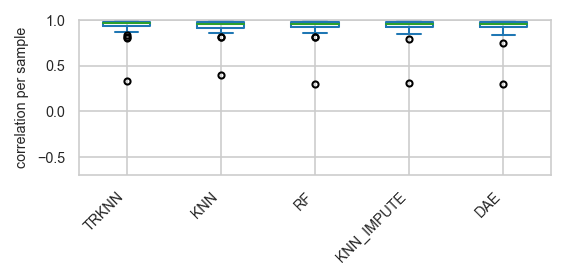

In [26]:
corr_per_sample_val = (pred_val
                       .groupby(sample_index_name)
                       .aggregate(
                           lambda df: df.corr().loc[TARGET_COL]
                       )[ORDER_MODELS])

min_corr = int(corr_per_sample_val.min().min() * 10) / 10
kwargs = dict(ylim=(min_corr, 1), rot=90,
              #     boxprops=dict(linewidth=1.5),
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model pred. per sample on validation data',
              ylabel='correlation per sample')
ax = corr_per_sample_val[TOP_N_ORDER].plot.box(**kwargs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

fname = args.out_figures / f'2_{group}_pred_corr_val_per_sample.xlsx'
dumps[fname.stem] = fname
with pd.ExcelWriter(fname) as w:
    corr_per_sample_val.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_val.to_excel(w, sheet_name='correlations')

identify samples which are below lower whisker for models

In [27]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_val[TOP_N_ORDER]).min()
mask = (corr_per_sample_val[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_val.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE
Sample ID,,,,,,,,,,,,,,,,,,
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,0.814638,0.872173,0.808759,0.840552,0.852062,0.814974,0.822477,0.834059,0.800987,0.734834,0.773389,0.773389,0.264915,0.702924,0.794515,0.731728,0.748825,0.282231
2020_01_04_10_03_Q-Exactive-HF-X-Orbitrap_6070,0.862972,0.815538,0.927120,0.792961,0.882167,0.854551,0.837722,0.768582,0.948465,0.893126,0.940723,0.940723,0.512767,0.688115,0.908134,0.965446,0.831855,-0.290724
2020_01_09_11_07_Q-Exactive-HF-X-Orbitrap_6070,0.333943,0.394118,0.291915,0.309707,0.295914,0.343051,0.231197,0.132317,0.228773,0.265304,0.265338,0.265338,-0.009020,0.291254,0.073737,0.032667,0.117483,-0.268213
2020_05_20_15_35_Q-Exactive-HF-X-Orbitrap_6070,0.804230,0.812842,0.817878,0.841829,0.746231,0.844776,0.739775,0.725347,0.887560,0.713875,0.877112,0.877112,-0.183033,0.713903,0.867014,0.862799,0.809157,nan


### Error plot

In [28]:
c_error_min = 4.5
mask = (errors_val[MODELS].abs() > c_error_min).any(axis=1)
errors_val.loc[mask].sort_index(level=1).head()

,,Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,
2020_02_11_10_35_Q-Exactive-HF-X-Orbitrap_6070,AAR2,-1.802,-0.203,-0.812,-1.320,-0.119,-1.802,-0.674,-0.474,-0.932,1.188,-3.667,0.291,-0.124,-0.338,-0.328,-0.523,-3.330,-4.816
2020_01_09_11_07_Q-Exactive-HF-X-Orbitrap_6070,ABCB6,-6.386,-3.382,-8.522,-6.361,-6.653,-6.386,-7.178,-6.696,-7.390,-7.865,-10.105,-3.636,-8.729,"2,546.526",-8.538,-7.582,-9.416,-10.569
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ABCB6,-2.347,0.877,-0.239,-2.047,-0.342,-2.347,-0.146,0.173,-0.563,-0.535,-6.810,2.063,0.123,"2,321.266",-0.013,0.040,-3.378,-5.796
2020_05_14_17_28_Q-Exactive-HF-X-Orbitrap_6070,ABCB6,0.861,3.834,-0.455,0.787,-0.853,0.861,-0.782,-0.287,-0.214,-0.455,-1.192,2.496,-0.474,"2,449.959",-0.371,-0.125,-2.008,-1.668
2020_02_11_10_35_Q-Exactive-HF-X-Orbitrap_6070,ABHD11,-1.686,1.689,-0.733,-1.461,-0.859,-1.686,-0.236,-0.400,-0.934,0.523,-5.650,1.908,-0.263,2.605,-0.096,-0.621,-3.521,-4.142


In [29]:
errors_val = errors_val.abs().groupby(
    freq_feat.index.name).mean()  # absolute error
errors_val = errors_val.join(freq_feat)
errors_val = errors_val.sort_values(by=freq_feat.name, ascending=True)
errors_val.head()

,Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP,freq
Gene Names,,,,,,,,,,,,,,,,,,,
SLC16A7,1.253,2.690,0.828,0.900,0.576,1.253,1.506,0.440,0.743,0.511,2.659,3.081,0.289,"1,504.411",0.305,0.446,2.829,2.359,30
ABHD11,1.532,2.095,0.851,1.274,0.903,1.532,0.403,0.447,0.859,0.887,4.857,2.512,0.422,"1,734.170",0.644,0.672,3.242,3.632,30
RPP38,1.957,3.971,0.518,1.406,0.855,1.957,0.732,0.547,0.889,0.494,1.958,3.221,0.565,"1,650.202",0.592,0.874,2.029,1.463,30
LIPA,0.704,2.294,0.494,0.380,0.422,0.704,0.500,0.195,0.455,0.559,2.750,2.934,0.563,"1,143.923",0.765,0.304,2.091,2.641,30
NSMCE2,1.605,1.271,0.989,1.654,1.045,1.605,1.299,1.372,1.246,1.006,4.784,1.117,1.021,"1,530.014",0.852,1.152,3.993,3.925,31


In [30]:
errors_val.describe()[ORDER_MODELS].T  # mean of means

,count,mean,std,min,25%,50%,75%,max
TRKNN,344.000,0.525,0.461,0.008,0.223,0.415,0.653,3.672
KNN,344.000,0.551,0.488,0.001,0.249,0.423,0.700,3.905
RF,344.000,0.554,0.482,0.000,0.248,0.435,0.705,3.689
KNN_IMPUTE,344.000,0.578,0.475,0.001,0.265,0.460,0.731,3.361
DAE,344.000,0.587,0.501,0.005,0.267,0.452,0.701,3.538
SEQKNN,344.000,0.617,0.608,0.011,0.260,0.460,0.752,7.013
MICE-NORM,344.000,0.586,0.461,0.007,0.287,0.487,0.713,3.304
IRM,344.000,0.653,0.507,0.007,0.313,0.537,0.839,3.877
VAE,344.000,0.866,0.620,0.016,0.461,0.704,1.094,3.358
IMPSEQ,344.000,0.975,0.966,0.008,0.423,0.705,1.188,7.120


In [31]:
c_avg_error = 2
mask = (errors_val[TOP_N_ORDER] >= c_avg_error).any(axis=1)
errors_val.loc[mask]

,Median,CF,DAE,VAE,KNN,ROWMEDIAN,KNN_IMPUTE,SEQKNN,RF,IMPSEQ,QRILC,SVDMETHOD,MICE-NORM,MLE,IRM,TRKNN,MSIMPUTE_MNAR,GSIMP,freq
Gene Names,,,,,,,,,,,,,,,,,,,
TMEM261,1.043,3.703,1.462,1.118,2.435,1.043,1.117,1.365,1.918,1.746,4.050,3.838,2.203,"2,407.758",2.584,2.050,1.327,2.042,32
UTRN,3.318,5.205,2.649,3.358,1.608,3.318,2.404,2.322,1.961,4.977,1.959,6.065,2.249,"2,336.949",2.371,3.109,0.365,2.049,32
ARPC1A,3.080,1.239,2.546,2.728,2.583,3.080,2.009,2.418,2.620,1.927,7.277,1.572,2.001,"2,427.903",2.061,2.064,5.177,6.509,34
ABCB6,3.198,2.698,3.072,3.065,2.616,3.198,2.702,2.385,2.722,2.951,6.036,2.732,3.109,"2,439.250",2.974,2.583,4.934,6.011,35
MED4,2.698,6.076,1.769,2.345,0.840,2.698,2.016,1.974,1.939,0.916,0.534,4.656,0.462,"2,363.715",1.304,1.533,0.003,0.556,37
EIF1B,1.426,2.396,1.683,0.422,2.732,1.426,0.585,0.240,1.611,7.120,4.527,2.282,0.703,2.564,0.383,0.972,2.696,3.318,41
OCRL,0.240,3.710,2.098,0.085,0.396,0.240,0.953,0.214,0.374,1.237,3.498,2.216,1.430,266.130,0.287,0.800,2.674,2.447,42
PRPF38B,1.906,4.285,1.896,2.000,2.077,1.906,1.668,2.038,1.858,2.138,2.640,3.826,2.569,"1,282.592",2.128,1.996,1.552,2.647,47
NDUFAF4,3.523,3.651,0.562,3.006,2.212,3.523,1.004,1.144,2.017,0.705,2.688,2.467,0.888,857.215,1.312,1.227,1.925,2.573,48


### Error by non-decimal number of intensity
- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_errors_binned_by_feat_median_val.pdf


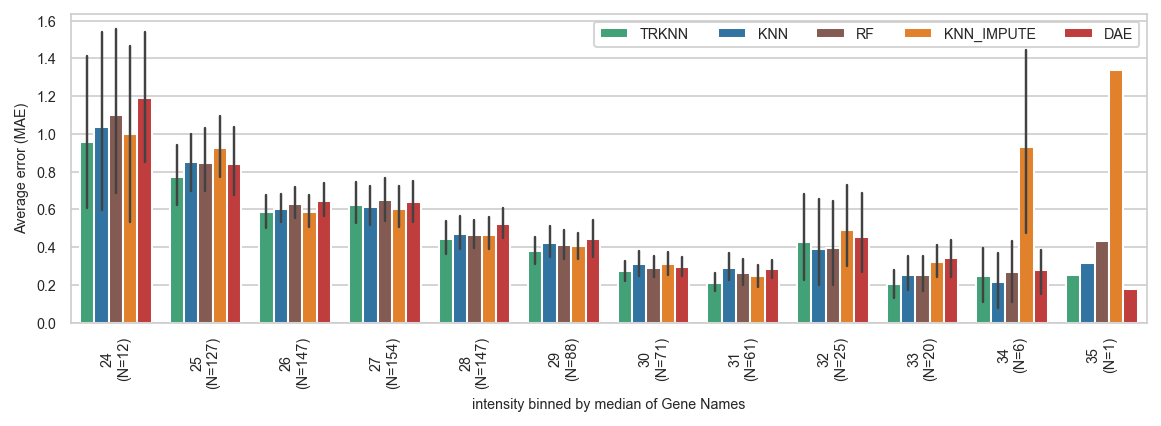

In [32]:
fig, ax = plt.subplots(figsize=(8, 3))
ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred_val[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,)
ax.set_ylabel(f"Average error ({METRIC})")
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_errors_binned_by_feat_median_val.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [33]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,24\n(N=12),TRKNN,0.957,0.600,1.400
1,24\n(N=12),KNN,1.039,0.612,1.530
2,24\n(N=12),RF,1.101,0.656,1.551
3,24\n(N=12),KNN_IMPUTE,0.998,0.521,1.463
4,24\n(N=12),DAE,1.193,0.826,1.559
...,...,...,...,...,...
55,35\n(N=1),TRKNN,0.251,NaN,NaN
56,35\n(N=1),KNN,0.315,NaN,NaN
57,35\n(N=1),RF,0.432,NaN,NaN
58,35\n(N=1),KNN_IMPUTE,1.338,NaN,NaN


In [34]:
errors_binned.head()
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,Gene Names,model,MAE,bin,n_obs,intensity binned by median of Gene Names
0,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,TRKNN,0.189,30,71,30\n(N=71)
1,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,KNN,0.081,30,71,30\n(N=71)
2,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,RF,0.294,30,71,30\n(N=71)
3,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,KNN_IMPUTE,0.162,30,71,30\n(N=71)
4,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,DAE,0.036,30,71,30\n(N=71)


## test data

In [35]:
pred_test = compare_predictions.load_split_prediction_by_modelkey(
    experiment_folder=args.folder_experiment,
    split='test',
    model_keys=MODELS_PASSED,
    shared_columns=[TARGET_COL])
pred_test = pred_test[[TARGET_COL] + ORDER_MODELS]
pred_test = pred_test.join(freq_feat, on=freq_feat.index.name)
if args.save_agg_pred:
    fname = args.folder_experiment / '01_2_agg_pred_test.csv'
    dumps[fname.stem] = fname
    pred_test.to_csv(fname)
    logger.info(f"Saved aggregated predictions to: {fname}")
pred_test

observed  TRKNN  \
Sample ID                                      Gene Names                    
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF          23.248 26.524   
                                               CENPH         25.045 24.908   
                                               CLPP          27.745 27.755   
                                               GNAI1         24.335 25.691   
                                               KIAA1143      26.901 26.690   
...                                                             ...    ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9         27.658 27.421   
                                               PTPN1         29.024 29.171   
                                               RDH13         28.720 28.445   
                                               RNASEH2C      26.742 26.920   
                                               SH3BGRL3      29.162 29.086   

                                                             KNN     RF  \
Sample ID                                      Gene Names                 
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF       25.862 25.663   
                                               CENPH      25.215 25.079   
                                               CLPP       27.337 27.519   
                                               GNAI1      26.067 25.704   
                                               KIAA1143   27.182 26.384   
...                                                          ...    ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9      27.114 27.408   
                                               PTPN1      28.058 28.708   
                                               RDH13      28.008 27.622   
                                               RNASEH2C   26.708 26.555   
                                               SH3BGRL3   28.613 29.348   

                                                           KNN_IMPUTE    DAE  \
Sample ID                                      Gene Names                      
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF            26.636 26.315   
                                               CENPH           24.850 24.767   
                                               CLPP            27.632 27.478   
                                               GNAI1           26.550 25.535   
                                               KIAA1143        26.642 26.407   
...                                                               ...    ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9           26.919 27.601   
                                               PTPN1           29.045 29.039   
                                               RDH13           28.395 28.486   
                                               RNASEH2C        26.698 26.775   
                                               SH3BGRL3        29.118 28.976   

                                                           SEQKNN  MICE-NORM  \
Sample ID                                      Gene Names                      
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARAF        26.451     25.461   
                                               CENPH       25.172     24.055   
                                               CLPP        27.572     28.114   
                                               GNAI1       26.096     25.747   
                                               KIAA1143    26.511     26.744   
...                                                           ...        ...   
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 NUDT9       27.742     27.356   
                                               PTPN1       29.134     28.712   
                                               RDH13       28.380     28.492   
                                               RNASEH2C    26.139     26.181   
                                               SH3BGRL3    29.372  

Write averages for all models to excel (from before?)

In [36]:
errors_test_mae = vaep.pandas.calc_errors.get_absolute_error(
    pred_test
)
mae_stats_ordered_test = errors_test_mae.describe()[ORDER_MODELS]
mae_stats_ordered_test

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE
count,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000,859.000
mean,0.474,0.513,0.493,0.506,0.537,0.524,0.543,0.596,0.848,0.850,1.040,1.040,1.829,1.930,2.636,2.705,2.986,"1,890.152"
std,0.533,0.521,0.503,0.528,0.542,0.534,0.540,0.568,0.714,1.053,0.824,0.824,1.396,1.412,0.976,1.477,1.591,954.223
min,0.000,0.001,0.002,0.001,0.001,0.001,0.001,0.001,0.003,0.001,0.003,0.003,0.005,0.005,0.006,0.009,0.005,0.017
25%,0.133,0.164,0.158,0.156,0.162,0.163,0.180,0.196,0.314,0.246,0.394,0.394,0.690,0.792,2.063,1.643,1.835,"2,219.520"
50%,0.308,0.372,0.348,0.339,0.386,0.368,0.386,0.439,0.683,0.527,0.875,0.875,1.489,1.661,2.708,2.611,2.851,"2,352.386"
75%,0.615,0.698,0.636,0.656,0.716,0.671,0.730,0.814,1.214,1.066,1.521,1.521,2.696,2.852,3.210,3.564,3.990,"2,432.080"
max,4.243,3.662,3.321,3.722,4.091,3.295,3.973,3.640,4.808,11.928,7.061,7.061,7.773,7.086,6.406,10.479,8.772,"2,683.112"


In [37]:
mae_stats_ordered_test.to_excel(writer, sheet_name='mae_stats_ordered_test', float_format='%.5f')

In [38]:
cp_mean_perf = pd.concat([
    mae_stats_ordered_val.loc['mean'],
    mae_stats_ordered_test.loc['mean'],
],
    axis=1,
    keys=['val', 'test']
).sort_values(by='val')
cp_mean_perf.to_excel(writer, sheet_name='cp_mean_perf', float_format='%.5f')
cp_mean_perf

,val,test
TRKNN,0.511,0.474
KNN,0.544,0.513
RF,0.549,0.493
KNN_IMPUTE,0.554,0.506
DAE,0.569,0.537
SEQKNN,0.580,0.524
MICE-NORM,0.593,0.543
IRM,0.646,0.596
VAE,0.841,0.848
IMPSEQ,0.914,0.850


In [39]:
writer.close()

### Intensity distribution as histogram
Plot top 4 models predictions for intensities in test data

vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_intensity_binned_top_4_models_test.pdf


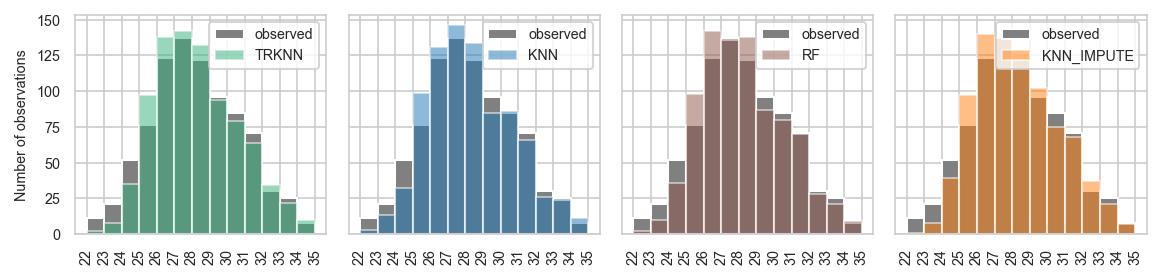

In [40]:
min_max = vaep.plotting.data.min_max(pred_test[TARGET_COL])
top_n = 4
fig, axes = plt.subplots(ncols=top_n, figsize=(8, 2), sharey=True)

for model, color, ax in zip(
        ORDER_MODELS[:top_n],
        COLORS_TO_USE[:top_n],
        axes):

    ax, bins = vaep.plotting.data.plot_histogram_intensities(
        pred_test[TARGET_COL],
        color='grey',
        min_max=min_max,
        ax=ax
    )
    ax, _ = vaep.plotting.data.plot_histogram_intensities(
        pred_test[model],
        color=color,
        min_max=min_max,
        ax=ax,
        alpha=0.5,
    )
    _ = [(l_.set_rotation(90))
         for l_ in ax.get_xticklabels()]
    ax.legend()

axes[0].set_ylabel('Number of observations')

fname = args.out_figures / f'2_{group}_intensity_binned_top_{top_n}_models_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [41]:
counts_per_bin = vaep.pandas.get_counts_per_bin(df=pred_test,
                                                bins=bins,
                                                columns=[TARGET_COL, *ORDER_MODELS[:top_n]])

counts_per_bin.to_excel(fname.with_suffix('.xlsx'))
counts_per_bin

,observed,TRKNN,KNN,RF,KNN_IMPUTE
bin,,,,,
"(22, 23]",11,2,3,2,1
"(23, 24]",21,8,13,10,8
"(24, 25]",52,35,32,36,39
"(25, 26]",76,97,99,98,97
"(26, 27]",123,138,131,142,140
"(27, 28]",137,142,146,136,137
"(28, 29]",122,132,134,138,127
"(29, 30]",96,94,85,87,102
"(30, 31]",85,79,86,80,75


### Correlation per sample

In [42]:
corr_per_sample_test = (pred_test
                        .groupby(sample_index_name)
                        .aggregate(lambda df: df.corr().loc[TARGET_COL])
                        [ORDER_MODELS])
corr_per_sample_test = corr_per_sample_test.join(
    pred_test
    .groupby(sample_index_name)[TARGET_COL]
    .count()
    .rename('n_obs')
)
too_few_obs = corr_per_sample_test['n_obs'] < 3
corr_per_sample_test.loc[~too_few_obs].describe()

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,n_obs
count,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,29.000,50.000
mean,0.951,0.950,0.953,0.949,0.942,0.949,0.940,0.929,0.923,0.850,0.928,0.928,0.238,0.814,0.925,0.879,0.864,0.039,17.180
std,0.043,0.047,0.037,0.044,0.057,0.038,0.049,0.056,0.059,0.137,0.061,0.061,0.344,0.072,0.052,0.087,0.077,0.284,4.241
min,0.776,0.738,0.845,0.797,0.690,0.801,0.804,0.756,0.719,0.297,0.730,0.730,-0.435,0.544,0.780,0.519,0.586,-0.396,10.000
25%,0.934,0.939,0.941,0.939,0.932,0.934,0.925,0.916,0.903,0.808,0.914,0.914,-0.035,0.782,0.910,0.859,0.820,-0.176,14.250
50%,0.965,0.962,0.965,0.965,0.956,0.961,0.950,0.945,0.947,0.881,0.948,0.948,0.257,0.822,0.939,0.903,0.887,0.020,16.000
75%,0.978,0.981,0.980,0.979,0.977,0.976,0.977,0.964,0.961,0.949,0.964,0.964,0.463,0.866,0.963,0.932,0.918,0.168,20.000
max,0.992,0.994,0.993,0.990,0.994,0.989,0.994,0.988,0.986,0.984,0.986,0.986,0.858,0.939,0.986,0.964,0.976,0.740,26.000


vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_pred_corr_test_per_sample.pdf


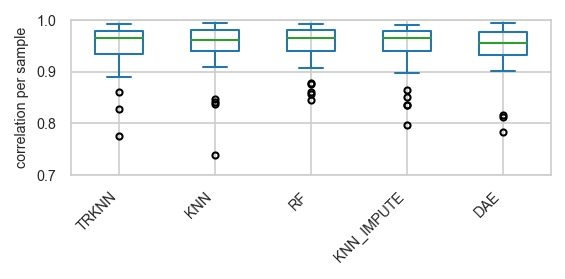

In [43]:
# ! add minimum
kwargs = dict(ylim=(0.7, 1), rot=90,
              flierprops=dict(markersize=3),
              # title='Corr. betw. fake NA and model predictions per sample on test data',
              ylabel='correlation per sample')
ax = (corr_per_sample_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_sample.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_sample_test.describe().to_excel(w, sheet_name='summary')
    corr_per_sample_test.to_excel(w, sheet_name='correlations')

identify samples which are below lower whisker for models

In [44]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_sample_test[TOP_N_ORDER]).min()
mask = (corr_per_sample_test[TOP_N_ORDER] < treshold).any(axis=1)
corr_per_sample_test.loc[mask].style.highlight_min(
    axis=1) if mask.sum() else 'Nothing to display'

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,n_obs
Sample ID,,,,,,,,,,,,,,,,,,,
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,0.776238,0.737708,0.860321,0.797078,0.690063,0.800713,0.804018,0.813479,0.851742,0.832118,0.836822,0.836822,0.343059,0.810295,0.801520,0.729185,0.690021,0.129713,13
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,0.889112,0.909160,0.877257,0.850543,0.904129,0.902232,0.852995,0.820761,0.733805,0.823477,0.729742,0.729742,-0.098112,0.668287,0.780364,0.685141,0.677034,0.020248,19
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070,0.860285,0.838000,0.876311,0.896348,0.812418,0.897088,0.809542,0.800993,0.907320,0.791691,0.913852,0.913852,0.171509,0.543815,0.807383,0.677395,0.785433,nan,11
2020_03_06_16_22_Q-Exactive-HF-X-Orbitrap_6070,0.828184,0.846603,0.856818,0.834826,0.783660,0.870369,0.851568,0.755935,0.803477,0.711289,0.732300,0.732300,0.213552,0.730298,0.794653,0.519357,0.585860,-0.305829,12
2020_05_14_14_46_Q-Exactive-HF-X-Orbitrap_6070,0.902006,0.840420,0.845016,0.835797,0.815711,0.845635,0.832429,0.757437,0.719305,0.828381,0.890895,0.890895,0.458540,0.780986,0.938423,0.889243,0.752434,nan,10


In [45]:
feature_names = pred_test.index.levels[-1]
N_SAMPLES = pred_test.index
M = len(feature_names)
pred_test.loc[pd.IndexSlice[:, feature_names[random.randint(0, M - 1)]], :]

,,observed,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,freq
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,IWS1,28.187,27.295,27.364,27.269,27.577,27.179,27.325,27.588,27.475,27.151,27.704,26.490,26.490,27.776,28.467,24.991,24.328,21.637,"2,507.702",49
2020_02_18_01_25_Q-Exactive-HF-X-Orbitrap_6070,IWS1,26.657,26.714,26.752,26.686,26.708,26.599,26.391,26.833,27.289,26.245,26.906,26.490,26.490,28.709,28.266,24.245,23.022,21.758,"2,389.379",49
2020_05_12_18_10_Q-Exactive-HF-X-Orbitrap_6070,IWS1,25.352,24.524,25.071,24.609,25.493,23.995,25.367,25.562,25.639,25.477,24.429,26.490,26.490,26.542,28.223,23.271,23.641,21.768,"2,437.956",49


In [46]:
options = random.sample(set(feature_names), 1)
pred_test.loc[pd.IndexSlice[:, options[0]], :]

,,observed,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,freq
Sample ID,Gene Names,,,,,,,,,,,,,,,,,,,,
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,FNTA,26.126,26.152,26.135,26.027,26.367,26.213,26.741,25.719,25.880,26.094,20.900,26.350,26.350,27.691,28.235,24.609,23.689,23.999,26.995,47


### Correlation per feature

In [47]:
corr_per_feat_test = pred_test.groupby(FEAT_NAME).aggregate(
    lambda df: df.corr().loc[TARGET_COL])[ORDER_MODELS]
corr_per_feat_test = corr_per_feat_test.join(pred_test.groupby(FEAT_NAME)[
    TARGET_COL].count().rename('n_obs'))

too_few_obs = corr_per_feat_test['n_obs'] < 3
corr_per_feat_test.loc[~too_few_obs].describe()

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,n_obs
count,152.000,152.000,152.000,152.000,152.000,152.000,152.000,152.000,152.000,152.000,0.000,0.000,152.000,152.000,152.000,152.000,152.000,152.000,152.000
mean,0.837,0.812,0.807,0.827,0.810,0.816,0.772,0.770,0.598,0.635,NaN,NaN,0.728,0.642,0.745,0.059,0.147,-0.012,3.809
std,0.342,0.340,0.384,0.345,0.390,0.348,0.412,0.401,0.499,0.498,NaN,NaN,0.397,0.442,0.409,0.626,0.629,0.672,1.059
min,-0.774,-0.959,-0.995,-0.953,-0.984,-0.798,-0.934,-0.988,-0.998,-0.942,NaN,NaN,-0.865,-0.993,-0.958,-1.000,-1.000,-1.000,3.000
25%,0.868,0.805,0.839,0.827,0.861,0.809,0.811,0.744,0.474,0.530,NaN,NaN,0.650,0.519,0.724,-0.486,-0.322,-0.682,3.000
50%,0.961,0.942,0.953,0.960,0.958,0.954,0.927,0.926,0.807,0.862,NaN,NaN,0.889,0.835,0.919,0.104,0.216,0.079,4.000
75%,0.989,0.984,0.984,0.987,0.991,0.989,0.982,0.981,0.936,0.951,NaN,NaN,0.969,0.938,0.986,0.599,0.743,0.565,4.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,NaN,1.000,1.000,1.000,1.000,0.997,0.988,8.000


In [48]:
corr_per_feat_test.loc[too_few_obs].dropna(thresh=3, axis=0)

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,n_obs
Gene Names,,,,,,,,,,,,,,,,,,,
ACTN1,1.000,1.000,1.000,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,1.000,NaN,NaN,-1.000,-1.000,-1.000,1.000,1.000,1.000,2
ACTR3,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,1.000,NaN,NaN,1.000,1.000,1.000,-1.000,-1.000,1.000,2
AP2S1,1.000,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,1.000,NaN,NaN,1.000,1.000,1.000,-1.000,1.000,1.000,2
ATP1A1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,NaN,1.000,1.000,1.000,1.000,1.000,1.000,2
ATP5J,1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,1.000,1.000,NaN,NaN,1.000,1.000,1.000,1.000,-1.000,-1.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VCP,-1.000,1.000,-1.000,-1.000,-1.000,-1.000,1.000,1.000,-1.000,-1.000,NaN,NaN,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,2
VPS29,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,NaN,1.000,-1.000,1.000,1.000,-1.000,-1.000,2
VPS33A,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN,NaN,-1.000,-1.000,-1.000,-1.000,1.000,-1.000,2


vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_pred_corr_test_per_feat.pdf


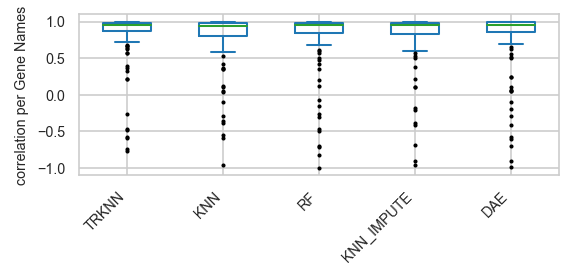

In [49]:
kwargs = dict(rot=90,
              flierprops=dict(markersize=1),
              ylabel=f'correlation per {FEAT_NAME_DISPLAY}')
ax = (corr_per_feat_test
      .loc[~too_few_obs, TOP_N_ORDER]
      .plot
      .box(**kwargs)
      )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       horizontalalignment='right')
fname = args.out_figures / f'2_{group}_pred_corr_test_per_feat.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)
dumps[fname.stem] = fname.with_suffix('.xlsx')
with pd.ExcelWriter(fname.with_suffix('.xlsx')) as w:
    corr_per_feat_test.loc[~too_few_obs].describe().to_excel(
        w, sheet_name='summary')
    corr_per_feat_test.to_excel(w, sheet_name='correlations')

In [50]:
feat_count_test = data.test_y.stack().groupby(FEAT_NAME).count()
feat_count_test.name = 'count'
feat_count_test.head()

Gene Names
AAR2     3
ABHD11   1
ACAD9    7
ACTL6A   3
ACTN1    2
Name: count, dtype: int64

In [51]:
treshold = vaep.pandas.get_lower_whiskers(
    corr_per_feat_test[TOP_N_ORDER]).min()
mask = (corr_per_feat_test[TOP_N_ORDER] < treshold).any(axis=1)


def highlight_min(s, color, tolerence=0.00001):
    return np.where((s - s.min()).abs() < tolerence, f"background-color: {color};", None)


view = (corr_per_feat_test
        .join(feat_count_test)
        .loc[mask]
        .sort_values('count'))

if not view.empty:
    display(view
            .style.
            apply(highlight_min, color='yellow', axis=1,
                  subset=corr_per_feat_test.columns)
            )
else:
    print("None found")

,TRKNN,KNN,RF,KNN_IMPUTE,DAE,SEQKNN,MICE-NORM,IRM,VAE,IMPSEQ,ROWMEDIAN,Median,SVDMETHOD,CF,MSIMPUTE_MNAR,QRILC,GSIMP,MLE,n_obs,count
Gene Names,,,,,,,,,,,,,,,,,,,,
ACTN1,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,nan,nan,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,2,2
MSH3,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,nan,nan,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2,2
NDUFAF3,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,nan,nan,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,2,2
POLR2J3;POLR2J;POLR2J2,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,nan,nan,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,2
PRKAA1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,nan,nan,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,2
PRMT7,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,nan,nan,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,2,2
PROCR,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,nan,nan,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2,2
PSMD14,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,nan,nan,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,2,2
MPP6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,nan,nan,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,2,2


### Error plot

In [52]:
metrics = vaep.models.Metrics()
test_metrics = metrics.add_metrics(
    pred_test[['observed', *TOP_N_ORDER]], key='test data')
test_metrics = pd.DataFrame(test_metrics)[TOP_N_ORDER]
test_metrics

Selected as truth to compare to: observed


,TRKNN,KNN,RF,KNN_IMPUTE,DAE
MSE,0.507,0.534,0.496,0.534,0.582
MAE,0.474,0.513,0.493,0.506,0.537
N,859.000,859.000,859.000,859.000,859.000
prop,1.000,1.000,1.000,1.000,1.000


In [53]:
n_in_comparison = int(test_metrics.loc['N'].unique()[0])
n_in_comparison

859

In [54]:
_to_plot = test_metrics.loc[METRIC].to_frame().T
_to_plot.index = [feature_names.name]
_to_plot

,TRKNN,KNN,RF,KNN_IMPUTE,DAE
Gene Names,0.474,0.513,0.493,0.506,0.537


In [55]:
try:
    text = model_configs[["latent_dim", "hidden_layers"]].apply(
        build_text,
        axis=1)
except KeyError:
    logger.warning("No PIMMS models in comparsion. Using empty text")
    text = pd.Series('', index=model_configs.columns)

_to_plot.loc["text"] = text
_to_plot = _to_plot.fillna('')
_to_plot

,TRKNN,KNN,RF,KNN_IMPUTE,DAE
Gene Names,0.474,0.513,0.493,0.506,0.537
text,,,,,LD: 10 HL: 512


vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_performance_test.pdf


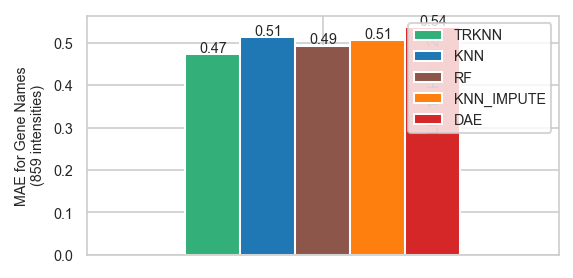

In [56]:
fig, ax = plt.subplots(figsize=(4, 2))  # size of the plot can be adjusted
ax = _to_plot.loc[[feature_names.name]].plot.bar(
    rot=0,
    ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY}\n({n_in_comparison:,} intensities)",
    # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
    color=COLORS_TO_USE,
    ax=ax,
    width=.7)
ax = vaep.plotting.add_height_to_barplot(ax, size=7)
ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=7)
ax.set_xticklabels([])
fname = args.out_figures / f'2_{group}_performance_test.pdf'
figures[fname.stem] = fname
vaep.savefig(fig, name=fname)

In [57]:
dumps[fname.stem] = fname.with_suffix('.csv')
_to_plot_long = _to_plot.T
_to_plot_long = _to_plot_long.rename(
    {feature_names.name: 'metric_value'}, axis=1)
_to_plot_long['data level'] = feature_names.name
_to_plot_long = _to_plot_long.set_index('data level', append=True)
_to_plot_long.to_csv(fname.with_suffix('.csv'))

### Plot error by median feature intensity

vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_test_errors_binned_by_feat_medians.pdf


,Sample ID,Gene Names,model,MAE,bin,n_obs,intensity binned by median of Gene Names
0,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,TRKNN,3.276,26,173,26\n(N=173)
1,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,KNN,2.614,26,173,26\n(N=173)
2,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,RF,2.415,26,173,26\n(N=173)
3,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,KNN_IMPUTE,3.388,26,173,26\n(N=173)
4,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,DAE,3.066,26,173,26\n(N=173)
...,...,...,...,...,...,...,...
"4,290",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,SH3BGRL3,TRKNN,0.076,28,140,28\n(N=140)
"4,291",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,SH3BGRL3,KNN,0.550,28,140,28\n(N=140)
"4,292",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,SH3BGRL3,RF,0.186,28,140,28\n(N=140)
"4,293",2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070,SH3BGRL3,KNN_IMPUTE,0.044,28,140,28\n(N=140)


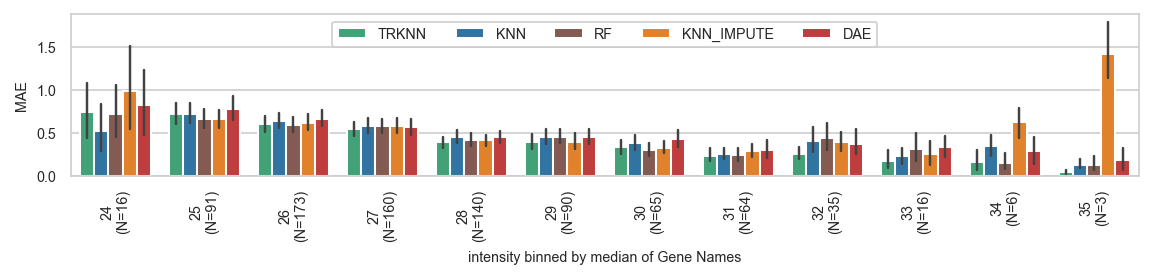

In [58]:
vaep.plotting.make_large_descriptors(7)
fig, ax = plt.subplots(figsize=(8, 2))

ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
    pred=pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    feat_medians=data.train_X.median(),
    ax=ax,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC,
    palette=COLORS_TO_USE
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
vaep.plotting.make_large_descriptors(6)
fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned

In [59]:
# ! only used for reporting
plotted = vaep.plotting.errors.get_data_for_errors_by_median(
    errors=errors_binned,
    feat_name=FEAT_NAME_DISPLAY,
    metric_name=METRIC
)
plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
plotted

,bin,model,mean,ci_low,ci_high
0,24\n(N=16),TRKNN,0.738,0.427,1.090
1,24\n(N=16),KNN,0.523,0.285,0.823
2,24\n(N=16),RF,0.723,0.437,1.044
3,24\n(N=16),KNN_IMPUTE,0.982,0.560,1.515
4,24\n(N=16),DAE,0.826,0.484,1.203
...,...,...,...,...,...
55,35\n(N=3),TRKNN,0.044,0.018,0.074
56,35\n(N=3),KNN,0.131,0.097,0.190
57,35\n(N=3),RF,0.130,0.065,0.231
58,35\n(N=3),KNN_IMPUTE,1.420,1.135,1.791


In [60]:
(errors_binned
 .set_index(
     ['model', errors_binned.columns[-1]]
 )
 .loc[ORDER_MODELS[0]]
 .sort_values(by=METRIC))

,Sample ID,Gene Names,MAE,bin,n_obs
intensity binned by median of Gene Names,,,,,
30\n(N=65),2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,ERP29,0.000,30,65
28\n(N=140),2020_05_04_11_39_Q-Exactive-HF-X-Orbitrap_6070,NUP153,0.001,28,140
28\n(N=140),2020_05_14_14_46_Q-Exactive-HF-X-Orbitrap_6070,LIG3,0.002,28,140
31\n(N=64),2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,CKAP4,0.002,31,64
29\n(N=90),2020_01_08_16_43_Q-Exactive-HF-X-Orbitrap_6070,PSMD14,0.002,29,90
...,...,...,...,...,...
26\n(N=173),2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,3.276,26,173
27\n(N=160),2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,SUMO3,3.525,27,160
25\n(N=91),2020_05_28_04_06_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,3.527,25,91


### Custom model selection

In [61]:
if SEL_MODELS:
    metrics = vaep.models.Metrics()
    test_metrics = metrics.add_metrics(
        pred_test[['observed', *SEL_MODELS]], key='test data')
    test_metrics = pd.DataFrame(test_metrics)[SEL_MODELS]
    test_metrics

    n_in_comparison = int(test_metrics.loc['N'].unique()[0])
    n_in_comparison

    _to_plot = test_metrics.loc[METRIC].to_frame().T
    _to_plot.index = [feature_names.name]
    _to_plot

    try:
        text = model_configs[["latent_dim", "hidden_layers"]].apply(
            build_text,
            axis=1)
    except KeyError:
        logger.warning("No PIMMS models in comparsion. Using empty text")
        text = pd.Series('', index=model_configs.columns)

    _to_plot.loc["text"] = text
    _to_plot = _to_plot.fillna('')
    _to_plot

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = _to_plot.loc[[feature_names.name]].plot.bar(
        rot=0,
        ylabel=f"{METRIC} for {FEAT_NAME_DISPLAY} ({n_in_comparison:,} intensities)",
        # title=f'performance on test data (based on {n_in_comparison:,} measurements)',
        color=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS)),
        ax=ax,
        width=.7)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    ax = vaep.plotting.add_height_to_barplot(ax, size=5)
    ax = vaep.plotting.add_text_to_barplot(ax, _to_plot.loc["text"], size=5)
    ax.set_xticklabels([])

    fname = args.out_figures / f'2_{group}_performance_test_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(fig, name=fname)

    dumps[fname.stem] = fname.with_suffix('.csv')
    _to_plot_long = _to_plot.T
    _to_plot_long = _to_plot_long.rename(
        {feature_names.name: 'metric_value'}, axis=1)
    _to_plot_long['data level'] = feature_names.name
    _to_plot_long = _to_plot_long.set_index('data level', append=True)
    _to_plot_long.to_csv(fname.with_suffix('.csv'))

In [62]:
# custom selection
if SEL_MODELS:
    vaep.plotting.make_large_descriptors(7)
    fig, ax = plt.subplots(figsize=(8, 2))

    ax, errors_binned = vaep.plotting.errors.plot_errors_by_median(
        pred=pred_test[
            [TARGET_COL] + SEL_MODELS
        ],
        feat_medians=data.train_X.median(),
        ax=ax,
        metric_name=METRIC,
        feat_name=FEAT_NAME_DISPLAY,
        palette=vaep.plotting.defaults.assign_colors(
            list(k.upper() for k in SEL_MODELS))
    )
    # ax.set_ylim(0, 1.5)
    ax.legend(loc='best', ncols=len(SEL_MODELS))
    # for text in ax.legend().get_texts():
    #     text.set_fontsize(6)
    fname = args.out_figures / f'2_{group}_test_errors_binned_by_feat_medians_sel.pdf'
    figures[fname.stem] = fname
    vaep.savefig(ax.get_figure(), name=fname)
    plt.show(fig)

    dumps[fname.stem] = fname.with_suffix('.csv')
    errors_binned.to_csv(fname.with_suffix('.csv'))
    vaep.plotting.make_large_descriptors(6)
    # ax.xaxis.set_tick_params(rotation=0) # horizontal

    # ! only used for reporting
    plotted = vaep.plotting.errors.get_data_for_errors_by_median(
        errors=errors_binned,
        feat_name=FEAT_NAME_DISPLAY,
        metric_name=METRIC
    )
    plotted.to_excel(fname.with_suffix('.xlsx'), index=False)
    display(plotted)

### Error by non-decimal number of intensity

- number of observations in parentheses.

vaep.plotting - INFO     Saved Figures to runs/example/figures/2_1_test_errors_binned_by_int.pdf


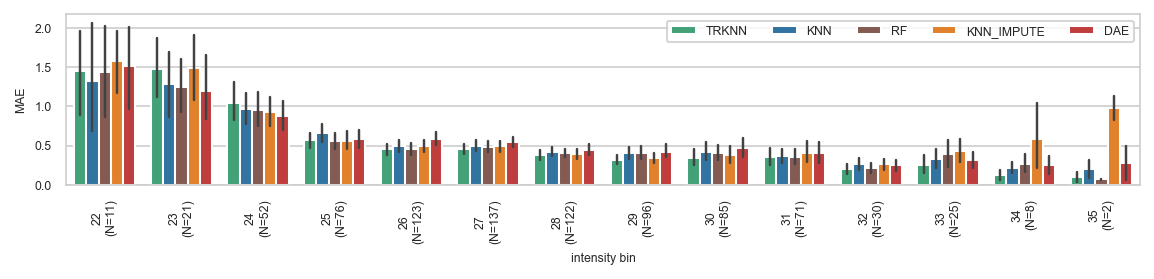

In [63]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_binned = vaep.plotting.errors.plot_errors_binned(
    pred_test[
        [TARGET_COL] + TOP_N_ORDER
    ],
    ax=ax,
    palette=TOP_N_COLOR_PALETTE,
    metric_name=METRIC,
)
ax.legend(loc='best', ncols=len(TOP_N_ORDER))
fname = args.out_figures / f'2_{group}_test_errors_binned_by_int.pdf'
figures[fname.stem] = fname
vaep.savefig(ax.get_figure(), name=fname)

In [64]:
dumps[fname.stem] = fname.with_suffix('.csv')
errors_binned.to_csv(fname.with_suffix('.csv'))
errors_binned.head()

,Sample ID,Gene Names,model,MAE,intensity bin
0,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,TRKNN,3.276,23\n(N=21)
1,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,KNN,2.614,23\n(N=21)
2,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,RF,2.415,23\n(N=21)
3,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,KNN_IMPUTE,3.388,23\n(N=21)
4,2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,ARAF,DAE,3.066,23\n(N=21)


## Figures dumped to disk

In [65]:
figures

{'2_1_fake_na_val_test_splits': Path('runs/example/figures/2_1_fake_na_val_test_splits.png'),
 '2_1_pred_corr_val_per_sample': Path('runs/example/figures/2_1_pred_corr_val_per_sample.pdf'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/example/figures/2_1_errors_binned_by_feat_median_val.pdf'),
 '2_1_intensity_binned_top_4_models_test': Path('runs/example/figures/2_1_intensity_binned_top_4_models_test.pdf'),
 '2_1_pred_corr_test_per_sample': Path('runs/example/figures/2_1_pred_corr_test_per_sample.pdf'),
 '2_1_pred_corr_test_per_feat': Path('runs/example/figures/2_1_pred_corr_test_per_feat.pdf'),
 '2_1_performance_test': Path('runs/example/figures/2_1_performance_test.pdf'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/example/figures/2_1_test_errors_binned_by_feat_medians.pdf'),
 '2_1_test_errors_binned_by_int': Path('runs/example/figures/2_1_test_errors_binned_by_int.pdf')}

In [66]:
dumps

{'01_2_performance_summary': Path('runs/example/01_2_performance_summary.xlsx'),
 '2_1_pred_corr_val_per_sample': Path('runs/example/figures/2_1_pred_corr_val_per_sample.xlsx'),
 '2_1_errors_binned_by_feat_median_val': Path('runs/example/figures/2_1_errors_binned_by_feat_median_val.csv'),
 '2_1_pred_corr_test_per_sample': Path('runs/example/figures/2_1_pred_corr_test_per_sample.xlsx'),
 '2_1_pred_corr_test_per_feat': Path('runs/example/figures/2_1_pred_corr_test_per_feat.xlsx'),
 '2_1_performance_test': Path('runs/example/figures/2_1_performance_test.csv'),
 '2_1_test_errors_binned_by_feat_medians': Path('runs/example/figures/2_1_test_errors_binned_by_feat_medians.csv'),
 '2_1_test_errors_binned_by_int': Path('runs/example/figures/2_1_test_errors_binned_by_int.csv')}